In [1]:
%load_ext autoreload
%autoreload 2

from blochK import Hamiltonian2D
import blochK
from blochK.plotting import plot_FS, plot_bandstruc

import numpy as np
from numpy import pi,cos,sin,exp

import matplotlib.pyplot as plt
import matplotlib

from blochK.plotting.utils import extent #for getting the correct extent

# Defining the Haldane model

First, we define the Haldane model which consits of NN hoppings on the Honeycomb model, NNN imaginary hoppings and a sublattice potential.

In [77]:
n1 = np.array([ 0.5,np.sqrt(3)/2])
n2 = np.array([-0.5,np.sqrt(3)/2])

def Haldane_fct(kx,ky, t=1, t2=0, m=0, mu=0):
    """Defining the Haldane model."""
    Hk = np.zeros((2,2,*kx.shape), dtype=complex)

    kdotn1 = kx * n1[0] + ky * n1[1]
    kdotn2 = kx * n2[0] + ky * n2[1]
    f = 1 + np.exp(1j*kdotn1) + np.exp(1j*kdotn2)
    g = np.sin(kdotn1) - np.sin(kdotn2) + np.sin(kdotn2 - kdotn1)
    # NNN vectors (same-sublattice)
    b1 = n1 - n2
    b2 = -n1
    b3 = -n2
    kdotb1 = kx * b1[0] + ky * b1[1]
    kdotb2 = kx * b2[0] + ky * b2[1]
    kdotb3 = kx * b3[0] + ky * b3[1]
    dz0 = - mu
    dz  = m + 2.0 * t2 * (np.sin(kdotb1) + np.sin(kdotb2) + np.sin(kdotb3))


    Hk[0,0] = dz0 + dz
    Hk[1,1] = dz0 - dz
    Hk[0,1] = -t * f
    Hk = blochK.hamiltonian_fct.make_hermitian(Hk)
    
    return Hk

Haldane = Hamiltonian2D(Haldane_fct, n1=n1, n2=n2, basis=['sublattice'],basis_states=['A','B'])
Haldane.add_operator('sublattice',np.array([1,-1]))

Haldane.BZ.set_points({
    'K':  (Haldane.BZ.m1 + 2*Haldane.BZ.m2)/3,
    "K'": (2*Haldane.BZ.m1 + Haldane.BZ.m2)/3
})

TypeError: Haldane_fct() got an unexpected keyword argument 'phi'

The Bandstructure shows two inequivalent valleys.

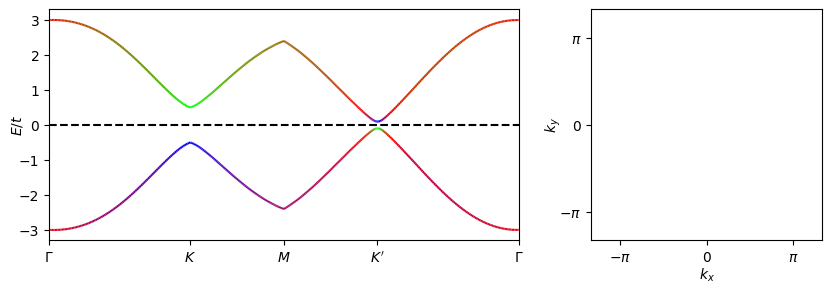

In [78]:
#Haldane model is topological for |t2|>sqrt(3)*m
Haldane.update_params(dict(t2=-0.2/(3**0.5)*1.5,m=0.2))

fig, [ax,ax1] = plt.subplots(1,2,gridspec_kw={'width_ratios': [2,1]},figsize=(10,3))
labels = ['\Gamma',"K",'M',"K'",'\Gamma']
coloring_operator = Haldane.operator.sublattice

plot_bandstruc(ax,Haldane,labels_points_path=labels,coloring_operator=coloring_operator)
plot_FS(ax1,Haldane,coloring_operator=coloring_operator,kmesh='BZ')

## Computing topological quantities

The Berry curvature

$\Omega_{n; xy}(\vec{k}) = \mathrm{i} \left[ \left\langle \frac{\partial u_{n}}{\partial k_x}| \frac{\partial u_{n}}{\partial k_y} \right\rangle - \left\langle \frac{\partial u_{n}}{\partial k_y} \middle| \frac{\partial u_{n}}{\partial k_x} \right\rangle\right]$

Here it is evaluated using the Fukui–Hatsugai–Suzuki method, i.e. a numerically stable version where the flux through small plaquettes of the Brillouin zone is computed. 

In [79]:
import blochK.topology

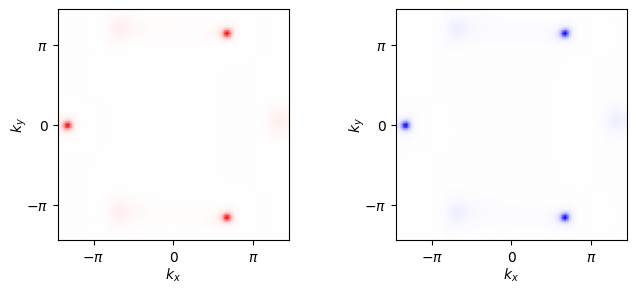

In [80]:
Lk = 101
ks = np.meshgrid(np.linspace(-4.6,4.6,Lk),np.linspace(-4.6,4.6,Lk),indexing='ij')
ks = np.array(ks)

#Berry curvature function returns the curvature and the kmesh which is trimmed of its edges
# If no kmesh is provided, it uses a the BZ of the Hamiltonian and the edges are not trimmed
berry_curvature,ks = blochK.topology.berry_curvature(Haldane,kmesh=ks) #shape=(nbands,Lk-2,Lk-2)


fig, axs = plt.subplots(1,2,figsize=(8,3))
vmax = np.max(np.abs(berry_curvature))
axs[0].imshow(berry_curvature[0].T,extent=extent(ks),origin='lower',cmap='bwr',vmin=-vmax,vmax=vmax)
axs[1].imshow(berry_curvature[1].T,extent=extent(ks),origin='lower',cmap='bwr',vmin=-vmax,vmax=vmax)

for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlabel(r'$k_x$',labelpad=1)
    ax.set_xticks([-pi,0,pi])
    ax.set_xticklabels([r'$-\pi$',0,r'$\pi$'])
    ax.set_ylabel(r'$k_y$',labelpad=-2.5)
    ax.set_yticks([-pi,0,pi])
    ax.set_yticklabels([r'$-\pi$',0,r'$\pi$'])
    ax.set_xticks([-pi,0,pi])
    ax.set_yticks([-pi,0,pi])

The Chern number 

$C_n = \frac{1}{2\pi} \sum_{\vec{k}}  \Omega_{n; xy}(\vec{k})$

calls the method 'berry_curvature' internally with a k-mesh which is automatically the BZ. It requires a gap between the bands.

In [81]:
blochK.topology.chern_number(Haldane)

array([ 1., -1.])

## Anomalous Hall conductivity

The anomalous Hall conductivity is set by the Berry curvature below the Fermi energy

$\sigma_{xy} = \frac{e^2}{\hbar} \frac{1}{2\pi} \sum_{\vec{k}} n_F(\epsilon(\vec{k}))  \Omega_{n; xy}(\vec{k})$

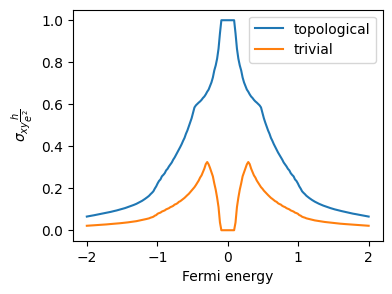

In [86]:
Lk = 100
energies = np.linspace(-2,2,200)

Haldane.update_params(dict(t2=-0.2/(3**0.5)*1.5,m=0.2))
cond_topo = blochK.topology.conductivity_anomalous_Hall(Haldane,energy=energies,Lk=Lk)

Haldane.update_params(dict(t2=-0.2/(3**0.5)*0.5,m=0.2))
cond_trivial = blochK.topology.conductivity_anomalous_Hall(Haldane,energy=energies,Lk=Lk)


fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(energies,cond_topo,label='topological')
ax.plot(energies,cond_trivial,label='trivial')

ax.set_xlabel('Fermi energy')
ax.set_ylabel(r'$\sigma_{xy} \frac{h}{e^2}$')
ax.legend()

In the topological phase the summed Berry curvature continously increases until it sums to 1, the Chern number of the lower band, when the Fermi energy is inside the gap. Inside the trivial phase inversion symmetry can also be broken ($K$ and $K'$ are not equivalent) such that at a given energy $\sigma_{xy} > 0$, because the Berry curvatures which compensate sit at different energies